In [1]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
# %matplotlib inline


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarn

In [2]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)


100%|██████████| 10000/10000 [00:02<00:00, 4853.67it/s]


In [3]:

# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor = Dense(1, activation = "relu")
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.

    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)

    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """

    s_prev_repeated = repeator(s_prev)
    concat = concatenator([s_prev_repeated, a])
    # e_pre = densor2(densor1(concat))  # Why to use two densor?
    e = densor(concat)
    alpha = activator(e)
    context = dotor([alpha, a])

    return context


In [4]:

n_a = 64 # 32
n_s = 128 # 64
# post_activation_LSTM_cell = LSTM(n_s, return_state = True)
# output_layer = Dense(len(machine_vocab), activation=softmax)

def model(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    Y = []

    pre_LSTM_layer = Bidirectional(LSTM(units=n_a, return_sequences=True))
    post_LSTM_cell = LSTM(n_s, return_state=True)
    output_densor = Dense(machine_vocab_size, activation=softmax)

    X = Input(shape=(Tx, human_vocab_size))
    a = pre_LSTM_layer(X)

    for t in range(Ty):
        context = one_step_attention(a, s)
        s, _, c = post_LSTM_cell(context, initial_state=[s, c])
        y = output_densor(s)
        Y.append(y)

    return Model(input=[X, s0, c0], output=Y)


In [5]:
# Initialize Model
model = model(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
s0 (InputLayer)                 (None, 128)          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 30, 37)       0                                            
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 30, 128)      0           s0[0][0]                         
                                                                 lstm_2[0][0]                     
                                                                 lstm_2[1][0]                     
                                                                 lstm_2[2][0]                     
          

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [6]:
# Train this Model
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01) # lr = learning_rate
model.compile(optimizer=opt ,loss='categorical_crossentropy', metrics=['accuracy'])

s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))

In [7]:
outputs = list(Yoh.swapaxes(0,1))
model.fit([Xoh, s0, c0], outputs, epochs=55, batch_size=100)

Epoch 1/55
10000/10000 [==============================] - 55s 6ms/step - loss: 14.8478 - dense_4_loss: 2.4908 - dense_4_acc: 0.5597 - dense_4_acc_1: 0.7554 - dense_4_acc_2: 0.3762 - dense_4_acc_3: 0.1105 - dense_4_acc_4: 0.9081 - dense_4_acc_5: 0.4924 - dense_4_acc_6: 0.1262 - dense_4_acc_7: 0.9279 - dense_4_acc_8: 0.3121 - dense_4_acc_9: 0.1221
Epoch 2/55
10000/10000 [==============================] - 33s 3ms/step - loss: 7.8082 - dense_4_loss: 2.0215 - dense_4_acc: 0.9663 - dense_4_acc_1: 0.9677 - dense_4_acc_2: 0.6545 - dense_4_acc_3: 0.2833 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 0.9351 - dense_4_acc_6: 0.4105 - dense_4_acc_7: 1.0000 - dense_4_acc_8: 0.5982 - dense_4_acc_9: 0.2594
Epoch 3/55
10000/10000 [==============================] - 33s 3ms/step - loss: 5.9382 - dense_4_loss: 1.7036 - dense_4_acc: 0.9744 - dense_4_acc_1: 0.9745 - dense_4_acc_2: 0.7698 - dense_4_acc_3: 0.4853 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 0.9625 - dense_4_acc_6: 0.5963 - dense_4_acc_7: 1.0000 - dens

10000/10000 [==============================] - 32s 3ms/step - loss: 0.2339 - dense_4_loss: 0.0533 - dense_4_acc: 0.9999 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 0.9979 - dense_4_acc_3: 0.9970 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 0.9956 - dense_4_acc_6: 0.9742 - dense_4_acc_7: 1.0000 - dense_4_acc_8: 0.9956 - dense_4_acc_9: 0.9870
Epoch 48/55
10000/10000 [==============================] - 32s 3ms/step - loss: 0.2287 - dense_4_loss: 0.0516 - dense_4_acc: 0.9999 - dense_4_acc_1: 0.9998 - dense_4_acc_2: 0.9977 - dense_4_acc_3: 0.9968 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 0.9954 - dense_4_acc_6: 0.9744 - dense_4_acc_7: 1.0000 - dense_4_acc_8: 0.9954 - dense_4_acc_9: 0.9875
Epoch 49/55
10000/10000 [==============================] - 32s 3ms/step - loss: 0.2216 - dense_4_loss: 0.0508 - dense_4_acc: 0.9999 - dense_4_acc_1: 1.0000 - dense_4_acc_2: 0.9982 - dense_4_acc_3: 0.9969 - dense_4_acc_4: 1.0000 - dense_4_acc_5: 0.9966 - dense_4_acc_6: 0.9764 - dense_4_acc_7: 1.0000 - dense_4_acc_8:

In [13]:
# model.load_weights('models/model.h5')

In [8]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
for example in EXAMPLES:
    
    source = string_to_int(example, Tx, human_vocab)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source)))
    source = np.array([source])
    # print(source.shape)
    prediction = model.predict([source, s0, c0])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    
    print("source:", example)
    print("output:", ''.join(output))

source: 3 May 1979
output: 1979-05-03
source: 5 April 09
output: 2009-04-05
source: 21th of August 2016
output: 2016-08-21
source: Tue 10 Jul 2007
output: 2007-07-10
source: Saturday May 9 2018
output: 2018-05-09
source: March 3 2001
output: 2001-03-03
source: March 3rd 2001
output: 2001-03-03
source: 1 March 2001
output: 2001-03-01


<Figure size 432x288 with 0 Axes>

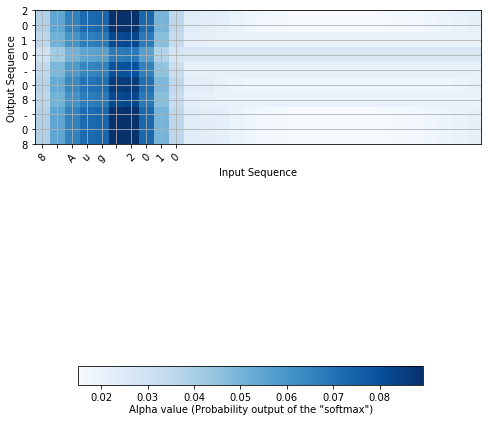

In [11]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "8 Aug 2010", num = 6, n_s = 128)